In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV

from sklearn.metrics import r2_score
from sktime.datasets import load_airline
from utils import get_best_lags_kernels,h_step_forecast
from TS_Extrinsic_Regression.models.rocket import RocketRegressor  as Rocket1
from TS_Extrinsic_Regression.models.rocket import generate_kernels,apply_kernels
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
y = load_airline()
#y_train, y_test = split_train_test(y.to_numpy())
train_size=90
y_train, y_test=y[:train_size],y[train_size:]


# Search for the best number of kernels and number of lags to use

In [3]:
diff_kernels=[1000,5000,10000,20000,50000,100000,200000]
results_r2=[]
results_time=[] 


results_r2,results_time=get_best_lags_kernels(8,13,diff_kernels,y,train_size)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
r2_df=pd.DataFrame(results_r2)
time_df=pd.DataFrame(results_time)
r2_df.columns=['num_kernels','num_lags','r2']
time_df.columns=['num_kernels','num_lags','time']
r2_df_sorted=r2_df.sort_values(by='r2',ascending=False)
r2_df_sorted.head(1)
r2_df_sorted.head(1).num_kernels.item()

1000

# 1-step ahead 

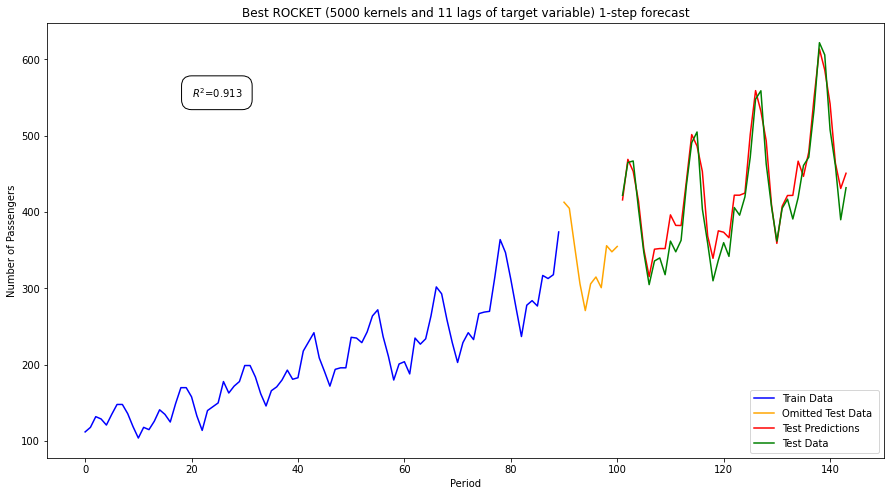

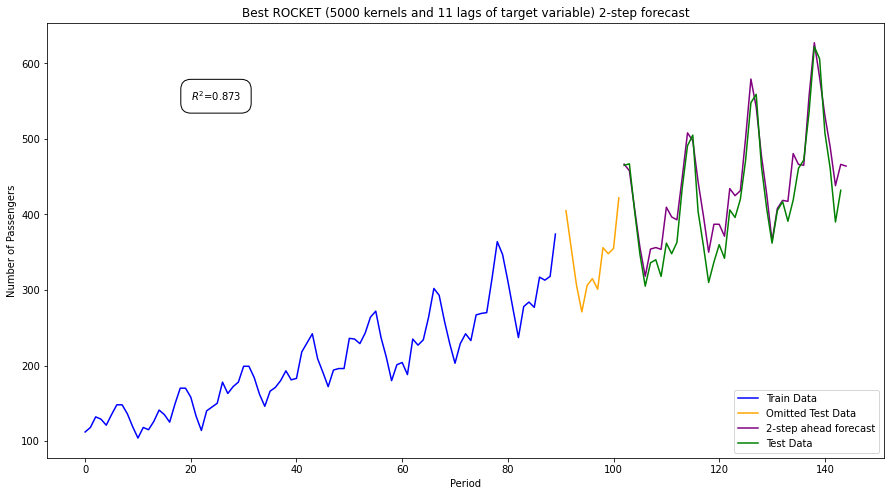

In [107]:
from TS_Extrinsic_Regression.models.rocket import generate_kernels,apply_kernels
from time import time
np.random.seed=13
n_kernels=r2_df_sorted.head(1).num_kernels.values[0]
num_lags=r2_df_sorted.head(1).num_lags.values[0]

one_step_forecast=h_step_forecast(n_kernels,num_lags,y,train_size,1)['pred t+1']

plt.figure(figsize=(15,8))
plt.plot(y_train.values,c='b',label='Train Data')
plt.plot(np.arange(train_size,train_size+num_lags),y_test[:num_lags].values,c='orange',label='Omitted Test Data ')

plt.plot(np.arange(train_size+num_lags,144),one_step_forecast,label='Test Predictions',c='r')
plt.plot(np.arange(train_size+num_lags,144),y_test[num_lags:].values,label='Test Data',c='g')
plt.legend(loc=4)
plt.ylabel('Number of Passengers')
plt.xlabel('Period')
plt.title('Best ROCKET (5000 kernels and 11 lags of target variable) 1-step forecast')
plt.text(x=20,y=550,s=f'$R^2$={np.round(r2_score(y_test[num_lags:],one_step_forecast),3)}', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
plt.show()

# 2-step ahead-forecast

two_step_forecast=h_step_forecast(n_kernels,num_lags,y,train_size,2)['pred t+2']
two_step_r2=r2_score(y_test[num_lags+1:],two_step_forecast[:-1])
plt.figure(figsize=(15,8))
plt.plot(y_train.values,c='b',label='Train Data')
plt.plot(np.arange(train_size+1,train_size+num_lags+1),y_test[1:num_lags+1].values,c='orange',label='Omitted Test Data ')

plt.plot(np.arange(train_size+num_lags+1,145),two_step_forecast,label='2-step ahead forecast',c='purple')
plt.plot(np.arange(train_size+num_lags+1,144),y_test[num_lags+1:].values,label='Test Data',c='g')
plt.legend(loc=4)
plt.ylabel('Number of Passengers')
plt.xlabel('Period')
plt.title('Best ROCKET (5000 kernels and 11 lags of target variable) 2-step forecast')
plt.text(x=20,y=550,s=f'$R^2$={np.round(two_step_r2,3)}', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
plt.show()


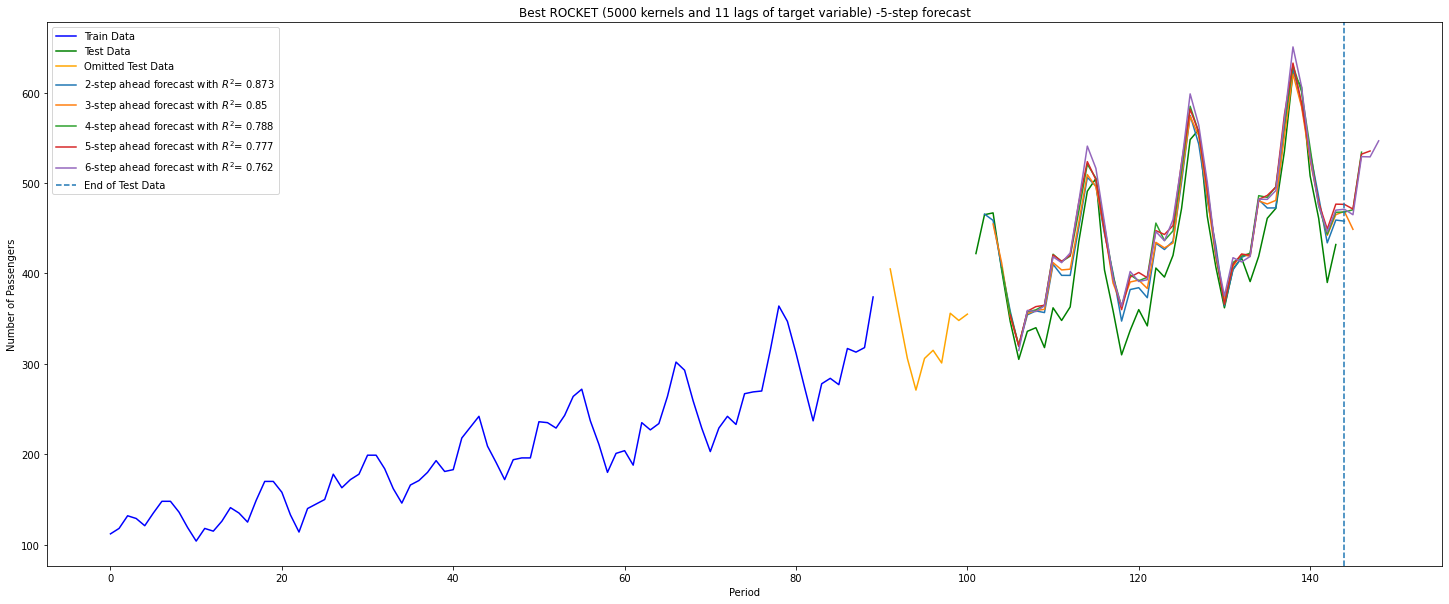

In [106]:
n_kernels=r2_df_sorted.head(1).num_kernels.values[0]
num_lags=r2_df_sorted.head(1).num_lags.values[0]
fig,ax=plt.subplots(1,1,figsize=(25,10))
ax.plot(y_train.values,c='b',label='Train Data')
ax.plot(np.arange(train_size+num_lags,144),y_test[num_lags:].values,label='Test Data',c='g')
ax.plot(np.arange(train_size+1,train_size+num_lags),y_test[1:num_lags].values,c='orange',label='Omitted Test Data ')

for i in range(2,7):
    forecast=h_step_forecast(n_kernels,num_lags,y,train_size,i)[f'pred t+{i}'].values
    h_step_r2=r2_score(y_test[num_lags+i-1:],forecast[:-i+1])
    ax.plot(np.arange(train_size+num_lags+i-1,144+i-1),forecast,label=f'{i}-step ahead forecast with $R^2$= {np.round(h_step_r2,3)}')
    ax.set_ylabel('Number of Passengers')
    ax.set_xlabel('Period')
ax.set_title(f'Best ROCKET (5000 kernels and 11 lags of target variable) {1-6}-step forecast')
    #ax.text(x=20,y=550,s=f'$R^2$={np.round(h_step_r2,3)}', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.axvline(x=144,ls='--',label='End of Test Data')
ax.legend(loc=2)

plt.show()

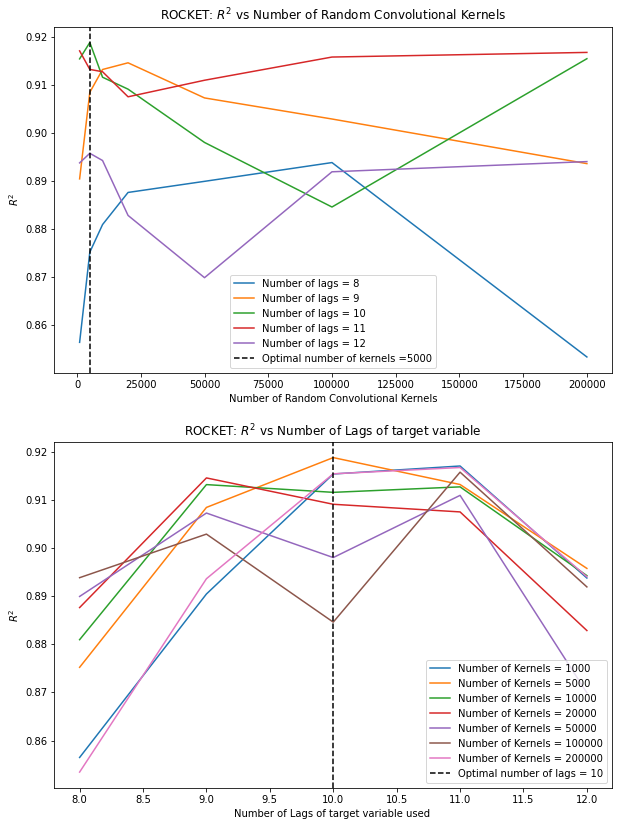

In [96]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,14))
for n in r2_df.num_lags.unique():
    ax1.plot(r2_df[r2_df.num_lags==n].num_kernels,r2_df[r2_df.num_lags==n].r2,label=f'Number of lags = {n}')
ax1.set_xlabel('Number of Random Convolutional Kernels')
ax1.set_ylabel('$R^2$')
ax1.axvline(r2_df_sorted.head(1).num_kernels.values[0],ls='--',c='k',label=f'Optimal number of kernels ={r2_df_sorted.head(1).num_kernels.values[0]}')


ax1.set_title('ROCKET: $R^2$ vs Number of Random Convolutional Kernels ')
ax1.legend()

for n in r2_df.num_kernels.unique():
    ax2.plot(r2_df[r2_df.num_kernels==n].num_lags,r2_df[r2_df.num_kernels==n].r2,label=f'Number of Kernels = {n}')
ax2.set_xlabel('Number of Lags of target variable used ')
ax2.set_ylabel('$R^2$')
ax2.set_title('ROCKET: $R^2$ vs Number of Lags of target variable ')
ax2.axvline(r2_df_sorted.head(1).num_lags.values[0],ls='--',c='k',label=f'Optimal number of lags = {r2_df_sorted.head(1).num_lags.values[0]}')

ax2.legend(loc='lower right')
plt.show()


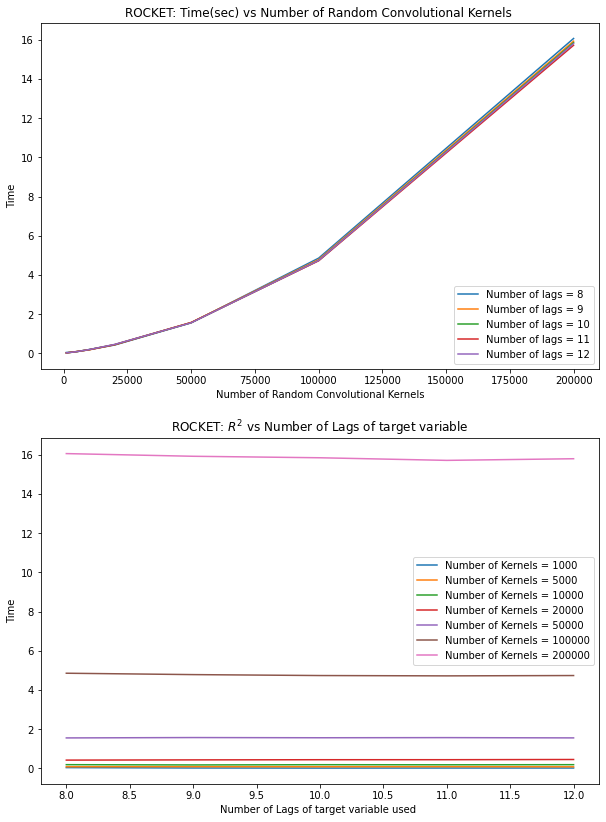

In [97]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,14))
for n in time_df.num_lags.unique():
    ax1.plot(time_df[time_df.num_lags==n].num_kernels,time_df[time_df.num_lags==n].time,label=f'Number of lags = {n}')
ax1.set_xlabel('Number of Random Convolutional Kernels')
ax1.set_ylabel('Time')
ax1.set_title('ROCKET: Time(sec) vs Number of Random Convolutional Kernels ')
ax1.legend(loc=4)

for n in time_df.num_kernels.unique():
    ax2.plot(time_df[time_df.num_kernels==n].num_lags,time_df[time_df.num_kernels==n].time,label=f'Number of Kernels = {n}')
ax2.set_xlabel('Number of Lags of target variable used ')
ax2.set_ylabel('Time')
ax2.set_title('ROCKET: $R^2$ vs Number of Lags of target variable ')
ax2.legend()

plt.show()